In [3]:
import os                   # to interact with the operating system
import glob

import numpy as np
import pandas as pd
import xarray as xr

import pop_tools
import gsw                  # compute potential density

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import matplotlib.ticker as ticker

In [4]:
# setting up of regional mask
grid_name = 'POP_gx1v7'
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7, 9]}, 
                             'bounds': {'TLAT': [20., 78.]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}]
} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

def find_corresponding_number(vvel_filename):
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_number_to_find = None
    for filename in vvel_list:
        if filename.split()[1] == vvel_filename:
            vvel_number_to_find = vvel_dict[filename.split()[1]]
            break
    return vvel_number_to_find

def find_corresponding_file_name(vvel_number_to_find):
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_filename = None
    for filename in vvel_list:
        if vvel_dict[filename.split()[1]] == vvel_number_to_find:
            vvel_filename = filename.split()[1]  
            break
    return vvel_filename

# Load data from 'events_dens_spg.csv' into a NumPy array.
data = np.genfromtxt('events_dens_spg.csv', delimiter=',', names=True, dtype=None)

# Accessing columns by name
member_numbers = data['Index']
events = data['Values']
member_names = []

for i in range(len(member_numbers)):
    member_names.append(find_corresponding_file_name(member_numbers[i])[5:])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Plot Barotropic stream function

In [5]:
filename = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/bsf/bsf_1001.001.nc'
ds_bsf = xr.open_dataset(filename)

# setting up of regional mask
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [15.0, 66.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}        
    ]}
maskBSF = pop_tools.region_mask_3d(grid_name, 
                                  region_defs=region_defs, 
                                  mask_name='Subpolar Gyre')
maskBSF = maskBSF.sum('region')  
ds_bsf = ds_bsf.where(maskBSF == 1)

In [6]:
# set kwargs
crs = cartopy.crs.PlateCarree()
vmin = -54
vmax = 54
levels = np.linspace(vmin, vmax, 28)
#cmap = cmo.balance
cmap = 'RdBu_r'
extent = [-78, -2, 20, 59]
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',linewidth=0.2, edgecolor='black', facecolor='darkgray')
title = 'Barotropic Streamfunction BSF'
path = '/home/innag3580/phase1_CONDA/results/'
save_name = 'NA_BSF.png'

In [7]:
slice(0, 30)

slice(0, 30, None)

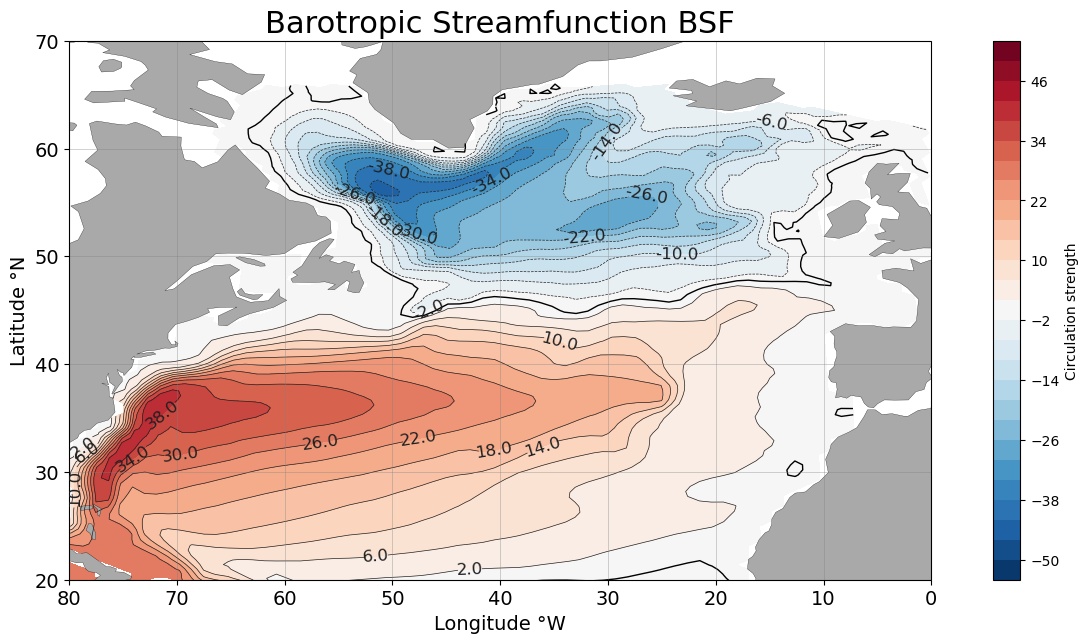

In [8]:
fig = plt.figure(figsize=(16, 7))
ax = plt.axes(projection=crs)
land = ax.add_feature(nature_coast)

ax.set_extent(extent)
ax.set_title(title, fontsize=22)
cf = ax.contourf(ds_bsf.TLONG.roll(nlon=-80), ds_bsf.TLAT.roll(nlon=-80), ds_bsf.BSF.isel(time=slice(0, 30)).mean('time').roll(nlon=-80), levels=levels, cmap=cmap, norm=norm)
cf2 = ax.contour(ds_bsf.TLONG.roll(nlon=-80), ds_bsf.TLAT.roll(nlon=-80), ds_bsf.BSF.isel(time=slice(0, 30)).mean('time').roll(nlon=-80), levels=levels, colors=['#202020', ], linewidths=0.5)
ax.clabel(cf2, inline=True, fontsize=12, fmt='%1.1f')
cf_zero_contour = ax.contour(ds_bsf.TLONG.roll(nlon=-80), ds_bsf.TLAT.roll(nlon=-80), ds_bsf.BSF.isel(time=slice(0, 30)).mean('time').roll(nlon=-80), levels=[0], colors=['black'], linewidths=1, linestyles='solid')
cbar = fig.colorbar(cf, ax=ax)
cbar.ax.set_ylabel('Circulation strength')

# Use MaxNLocator to set the number of ticks
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=9))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

# Manually set tick labels
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels([f'{int(abs(tick))}' for tick in xticks], fontsize=14)
ax.set_yticklabels([f'{int(tick)}' for tick in yticks], fontsize=14)
ax.set_ylabel('Latitude °N', fontsize=14)
ax.set_xlabel('Longitude °W', fontsize=14)
ax.gridlines(crs=crs, linewidth=0.5, color='gray', alpha=0.5, linestyle='-', draw_labels={'bottom': False, 'left': False, 'right': False, 'top': False})

#plt.show()
plt.savefig(path+save_name, bbox_inches='tight')

# Plot time series

In [9]:
raw_files = glob.glob(os.path.expanduser('~/phase1_CONDA/')+'timeseries/*time_series.npy')
hist_end = (2014-1850)*12
time_annual = np.arange(1850,1850+(hist_end/12))

signals = np.load(raw_files[7])
signal = signals[:,member_numbers[-3]]

In [10]:
signal = signal[:hist_end]

# Calculate the annual means by averaging the values in each row
reshaped_data = signal.reshape(-1, 12)
annual_mean = np.mean(reshaped_data, axis=1)

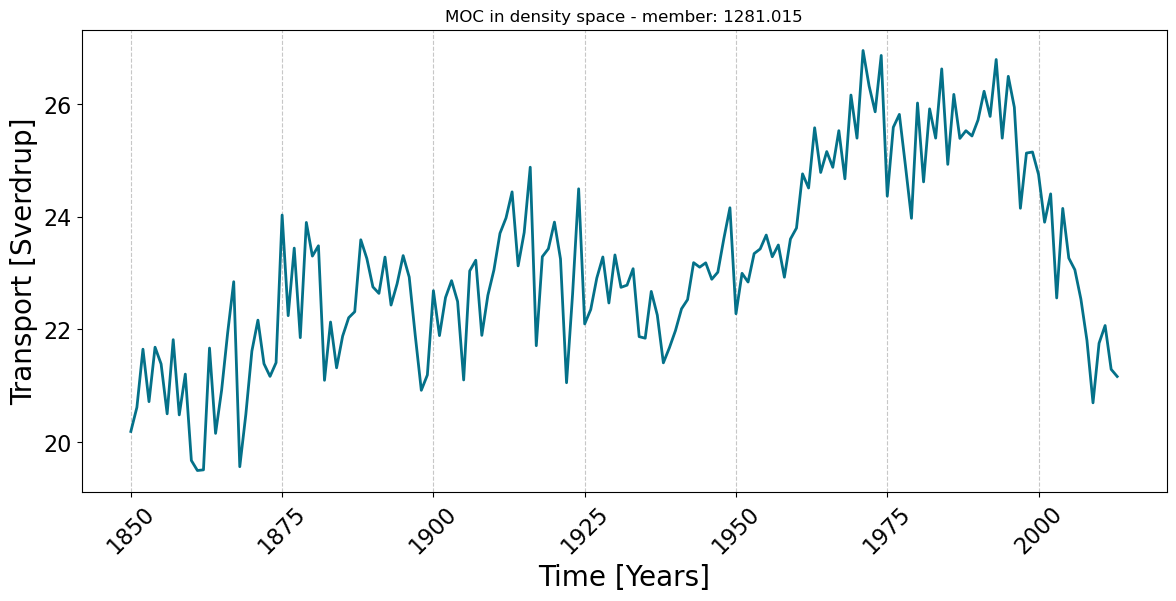

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(time_annual, annual_mean, linewidth=2, color='#047189')
plt.ylabel('Transport [Sverdrup]', fontsize=20)
plt.xlabel('Time [Years]', fontsize=20)
plt.title('MOC in density space - member: '+member_names[-3][:-3])
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.locator_params(axis='x', nbins=8)
plt.locator_params(axis='y', nbins=5)
plt.grid(axis='x', linestyle='--', alpha=0.7)

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'dens_MOC_'+member_names[-3][:-3]+'.png', bbox_inches='tight', dpi=300)

# Plot Composites

In [36]:
ccrs = cartopy.crs

### TEMP

In [37]:
difference_temp = ds_st.TEMP.isel(time=0, z_t=0)

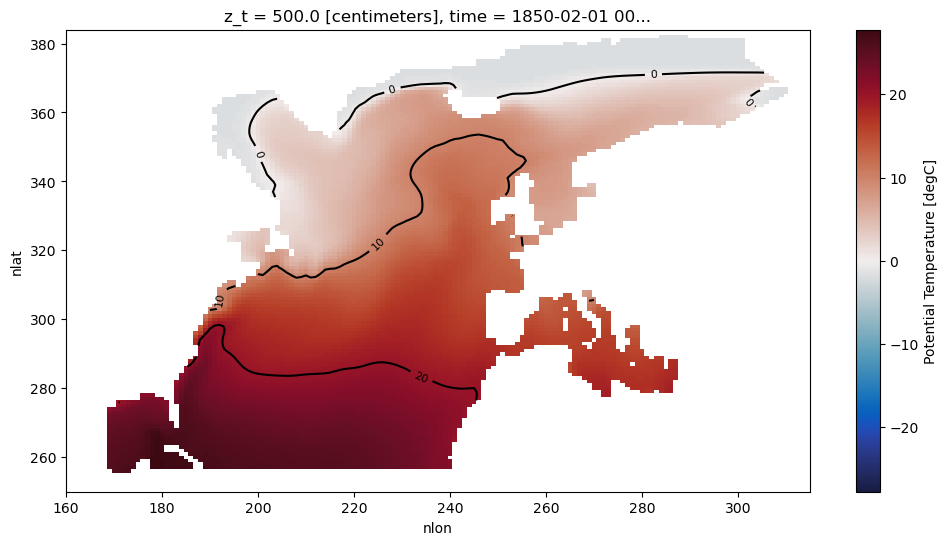

In [56]:
cmap = cmo.balance
cmap.set_bad('#92C7D0')

plt.figure(figsize=(12, 6))
temp_plot = difference_temp.plot(cmap=cmap)#, vmin=vmin_temp, vmax=vmax_temp)
contour_temp = difference_temp.plot.contour(colors='k') 
plt.clabel(contour_temp, inline=True, fontsize=8)

plt.xlim([167, 310])
plt.ylim([256, 384])
plt.ylabel('POP2 Latitudes')
plt.xlabel('POP2 Longitudes')
plt.title('Temperature Anomaly')
plt.show()

### SALT

In [27]:
difference_salt = ds_ss.SALT.isel(time=0, z_t=0)

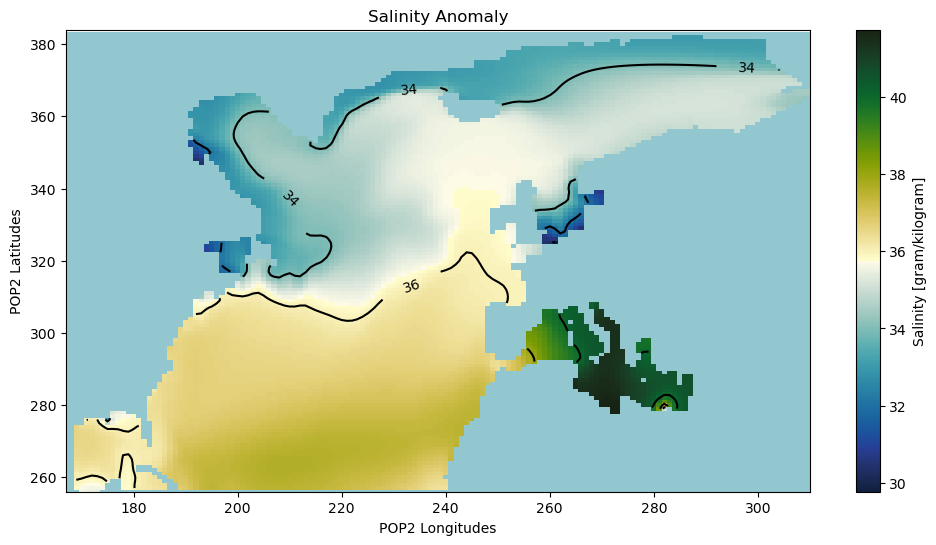

In [69]:
cmap = cmo.delta
cmap.set_bad('#92C7D0')

plt.figure(figsize=(12, 6))
salt_plot = difference_salt.plot(cmap=cmap)#, vmin=vmin_salt, vmax=vmax_salt)
contour_salt = difference_salt.plot.contour(colors='k') 
plt.clabel(contour_salt, inline=True, fontsize=10)

plt.xlim([167, 310])
plt.ylim([256, 384])
plt.ylabel('POP2 Latitudes')
plt.xlabel('POP2 Longitudes')
plt.title('Salinity Anomaly')
plt.show()

### DENS

#### horizontal map

In [29]:
difference_sigma = ds_sigma.SIGMA_2.isel(time=0,z_t=slice(14,20)).mean(dim='z_t')

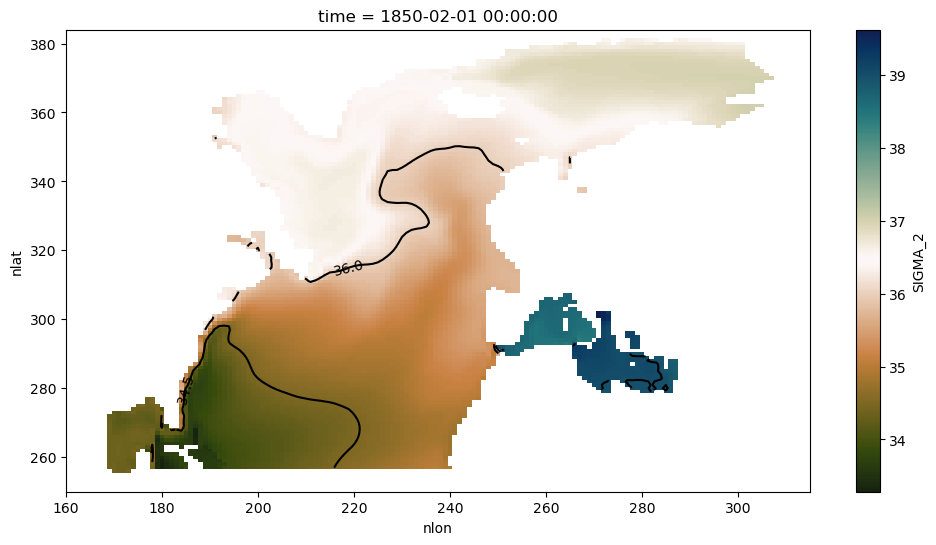

In [30]:
cmap = cmo.tarn
cmap.set_bad('#92C7D0')

plt.figure(figsize=(12, 6))
horiz_sigma_plot = difference_sigma.plot(cmap=cmo.tarn)#, vmin=vmin_sigma, vmax=vmax_sigma)
contour_salt = difference_sigma.plot.contour(colors='k') 
plt.clabel(contour_salt, inline=False, fontsize=10)

plt.xlim([167, 310])
plt.ylim([256, 384])
plt.ylabel('POP2 Latitudes')
plt.xlabel('POP2 Longitudes')
plt.title('Density Anomaly')
plt.show()

#### latitudinal section

In [31]:
difference_sigma = ds_sigma.SIGMA_2.isel(time=0,nlon=230)

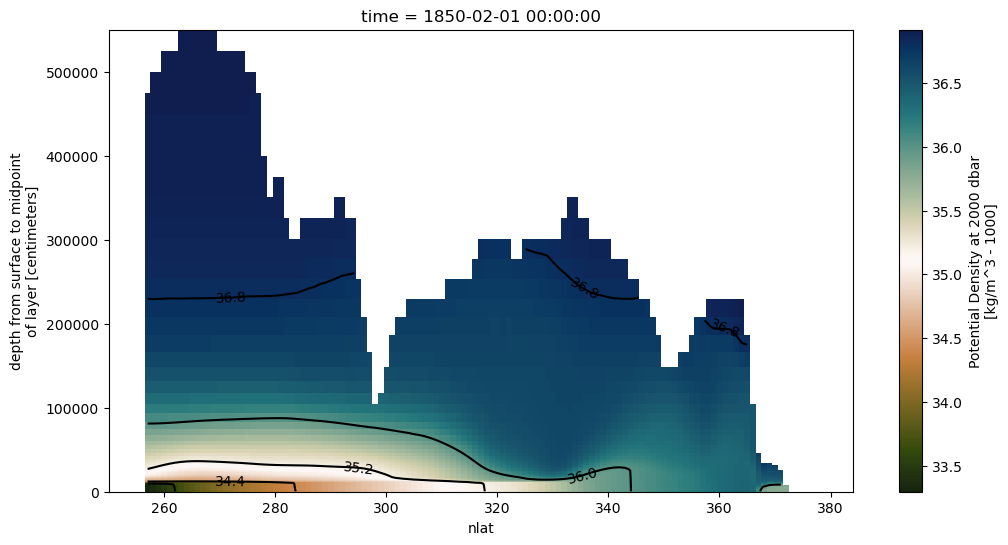

In [71]:
cmap = cmo.tarn
cmap.set_bad('#92C7D0')

plt.figure(figsize=(12, 6))
lati_sigma_plot = difference_sigma.plot(cmap=cmap,yincrease=False)#, vmin=vmin_salt, vmax=vmax_salt)
contour_salt = difference_sigma.plot.contour(colors='k') 
plt.clabel(contour_salt, inline=False, fontsize=10)

plt.xlim([256, 384])
plt.ylabel('Depth [centimeters]')
plt.xlabel('POP2 Latitudes')
plt.title('Density Anomaly')
plt.show()

### SHF

In [33]:
difference_shf = ds_shf.SHF.isel(time=0)

<a list of 12 text.Text objects>

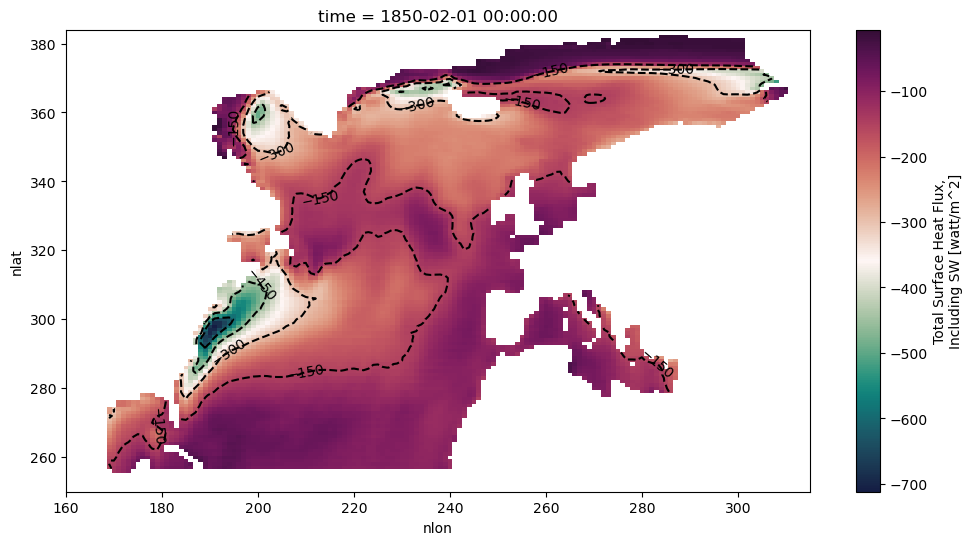

In [34]:
cmap = cmo.curl
cmap.set_bad('#92C7D0')

plt.figure(figsize=(12, 6))
shf_plot = difference_shf.plot(cmap=cmap)#, vmin=vmin_shf, vmax=vmax_shf)
contour_shf = difference_shf.plot.contour(colors='k') 
plt.clabel(contour_shf, inline=False, fontsize=10)

plt.xlim([167, 310])
plt.ylim([256, 384])
plt.ylabel('POP2 Latitudes')
plt.xlabel('POP2 Longitudes')
plt.title('Surface Heat Flux Anomaly')
plt.show

### HMXL

In [48]:
difference_hmxl = ds_hmxl.HMXL.isel(time=0)

<a list of 9 text.Text objects>

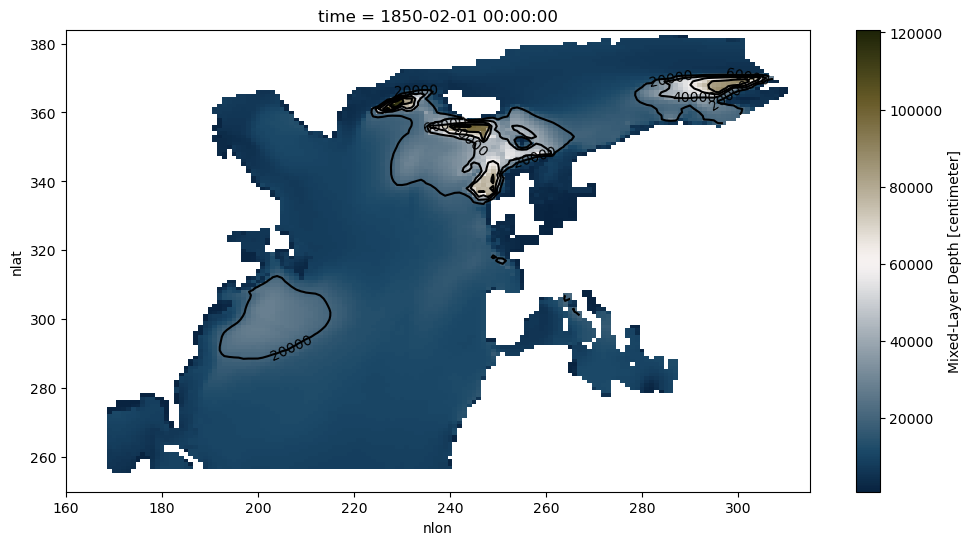

In [49]:
cmap = cmo.diff
cmap.set_bad('#92C7D0')

plt.figure(figsize=(12, 6))
difference_hmxl_plot = difference_hmxl.plot(cmap=cmap)#, vmin=vmin_hmxl, vmax=vmax_hmxl)
contour_hmxl = difference_hmxl.plot.contour(colors='k') 
plt.clabel(contour_hmxl, inline=False, fontsize=10)

plt.xlim([167, 310])
plt.ylim([256, 384])
plt.ylabel('POP2 Latitudes')
plt.xlabel('POP2 Longitudes')
plt.title('Mixed Layer Anomaly')
plt.show()

### SSH

In [51]:
difference_ssh = ds_ssh.SSH.isel(time=0)

<a list of 4 text.Text objects>

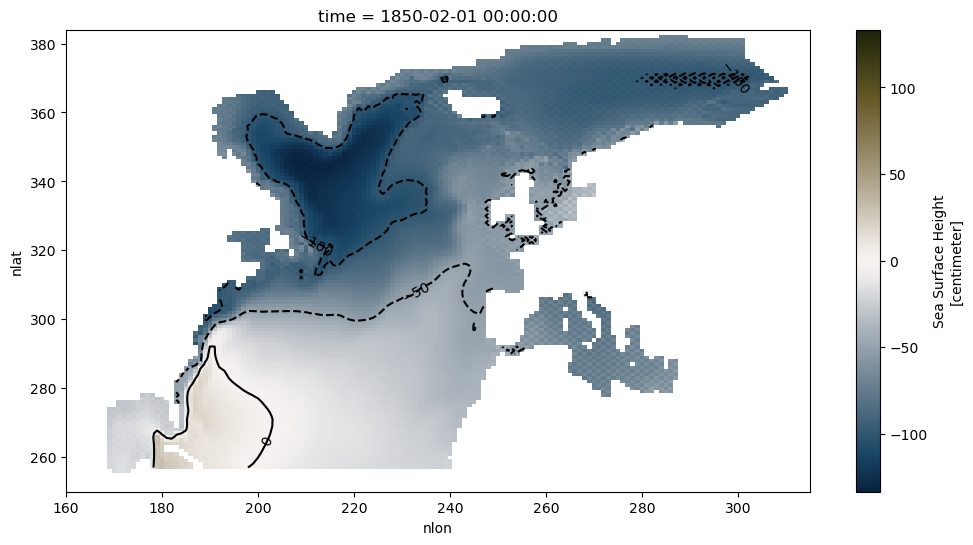

In [52]:
cmap = cmo.diff
cmap.set_bad('#92C7D0')

plt.figure(figsize=(12, 6))
difference_ssh_plot = difference_ssh.plot(cmap=cmap)#, vmin=vmin_ssh, vmax=vmax_ssh)
contour_ssh = difference_ssh.plot.contour(colors='k') 
plt.clabel(contour_ssh, inline=False, fontsize=10)

plt.xlim([167, 310])
plt.ylim([256, 384])
plt.ylabel('POP2 Latitudes')
plt.xlabel('POP2 Longitudes')
plt.title('Sea Surface Height Anomaly')
plt.show()

#
#
# Plot Anomalies for 1281.015
#
#


In [12]:
member = 'vvel_1281.015.nc'
csv_file = 'events_dens_spg.csv'
member_number = find_corresponding_number(member)
#event = get_value_for_index(csv_file, member_number)

In [14]:
# Set parameters
event = 107*12
before = 40*12
after = 20*12
tp = 3*12  

In [16]:
temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_'+member[5:]
#ds_sst = xr.open_dataset(temp_file).isel(z_t=0).where(mask3d == 1).roll(nlon=-100)
ds_st = xr.open_dataset(temp_file).where(mask3d == 1).roll(nlon=-100)

In [17]:
salt_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt/salt_'+member[5:]
#ds_sss = xr.open_dataset(salt_file).isel(z_t=0).where(mask3d == 1).roll(nlon=-100)
ds_ss = xr.open_dataset(salt_file).where(mask3d == 1).roll(nlon=-100)

In [18]:
hmxl_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/hmxl/hmxl_'+member[5:]
ds_hmxl = xr.open_dataset(hmxl_file).where(mask3d == 1).roll(nlon=-100)

In [22]:
ds_sigma = ds_st
ds_sigma = ds_sigma.update(ds_ss[["SALT"]])

### Compute potential density ref 2000dbar
# Conservative Temperature
CT = gsw.conversions.CT_from_pt(ds_sigma.SALT, ds_sigma.TEMP)
# potential density
ds_sigma['SIGMA_2'] = gsw.density.sigma2(ds_sigma.SALT, CT)
ds_sigma['SIGMA_2'].attrs['units'] = 'kg/m^3 - 1000'
ds_sigma['SIGMA_2'].attrs['long_name'] = 'Potential Density at 2000 dbar'

In [23]:
ssh_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/ssh/ssh_'+member[5:]
ds_ssh = xr.open_dataset(ssh_file).where(mask3d == 1).roll(nlon=-100)

In [24]:
shf_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/shf/shf_'+member[5:]
ds_shf = xr.open_dataset(shf_file).where(mask3d == 1).roll(nlon=-100)

# SST Anomalies

In [11]:
# Calculate averages for temperature
period1_avg_temp = ds_sst.TEMP.isel(time=slice(event-before, event-tp)).mean(dim='time')
period2_avg_temp = ds_sst.TEMP.isel(time=slice(event+tp, event+after)).mean(dim='time')
difference_temp = period2_avg_temp - period1_avg_temp

In [12]:
vmin_temp, vmax_temp = -4.0, 4.0 

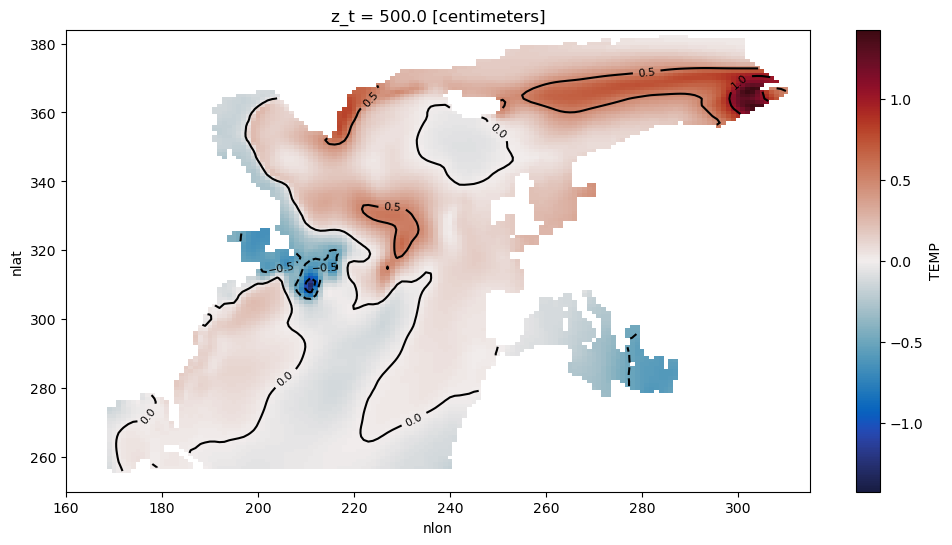

In [13]:
plt.figure(figsize=(12, 6))
#difference_temp_plot = difference_temp.plot(cmap=cmo.diff, vmin=vmin_temp, vmax=vmax_temp)
difference_temp_plot = difference_temp.plot(cmap=cmo.balance)#, vmin=vmin_temp, vmax=vmax_temp)
plt.title('Surface Temperature Anomaly')
plt.xlim([160, 315])
plt.ylim([250, 384])
contour_temp = difference_temp.plot.contour(colors='k') 
plt.clabel(contour_temp, inline=True, fontsize=8)
plt.show()

# SSS Anomalies

In [14]:
# Calculate averages for salinity
period1_avg_salt = ds_sss.SALT.isel(time=slice(event-before, event-tp)).mean(dim='time')
period2_avg_salt = ds_sss.SALT.isel(time=slice(event+tp, event+after)).mean(dim='time')
difference_salt = period2_avg_salt - period1_avg_salt

In [15]:
vmin_salt, vmax_salt = -1.0, 1.0  

<a list of 12 text.Text objects>

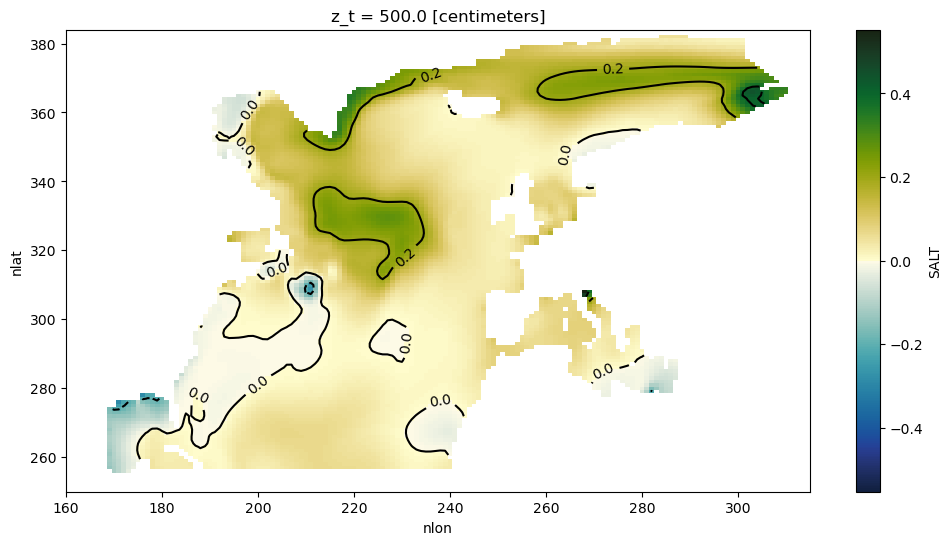

In [16]:
plt.figure(figsize=(12, 6))
#difference_salt_plot = difference_salt.plot(cmap=cmo.diff, vmin=vmin_salt, vmax=vmax_salt)
difference_salt_plot = difference_salt.plot(cmap=cmo.delta)#, vmin=vmin_salt, vmax=vmax_salt)
plt.title('Surface Salinity Anomaly')
plt.xlim([160, 315])
plt.ylim([250, 384])
contour_salt = difference_salt.plot.contour(colors='k') 
plt.clabel(contour_salt, inline=True, fontsize=10)

# HMXL Anomalies

In [17]:
# Calculate averages for mixed layer depth
period1_avg_hmxl = ds_hmxl.HMXL.isel(time=slice(event-before, event-tp)).mean(dim='time')
period2_avg_hmxl = ds_hmxl.HMXL.isel(time=slice(event+tp, event+after)).mean(dim='time')
difference_hmxl = period2_avg_hmxl - period1_avg_hmxl

In [18]:
#vmin_hmxl, vmax_hmxl = -1.0, 1.0  

<a list of 45 text.Text objects>

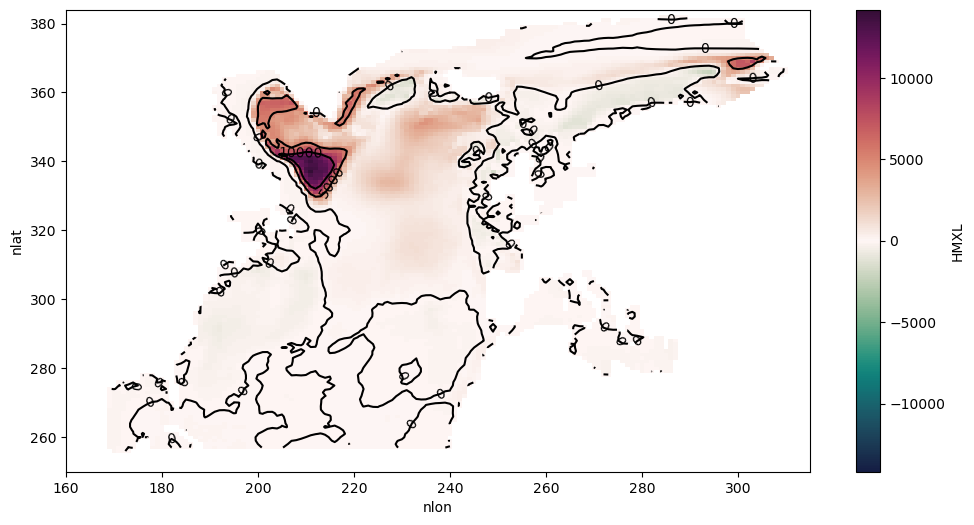

In [19]:
plt.figure(figsize=(12, 6))
#difference_hmxl_plot = difference_hmxl.plot(cmap=cmo.diff)#, vmin=vmin_hmxl, vmax=vmax_hmxl)
difference_hmxl_plot = difference_hmxl.plot(cmap=cmo.curl)#, vmin=vmin_hmxl, vmax=vmax_hmxl)
plt.title('Mixed Layer Anomaly')
plt.xlim([160, 315])
plt.ylim([250, 384])
contour_hmxl = difference_hmxl.plot.contour(colors='k') 
plt.clabel(contour_hmxl, inline=False, fontsize=10)

# SSH Anomalies

In [20]:
# Calculate averages for mixed layer depth
period1_avg_ssh = ds_ssh.SSH.isel(time=slice(event-before, event-tp)).mean(dim='time')
period2_avg_ssh = ds_ssh.SSH.isel(time=slice(event+tp, event+after)).mean(dim='time')
difference_ssh = period2_avg_ssh - period1_avg_ssh

<a list of 21 text.Text objects>

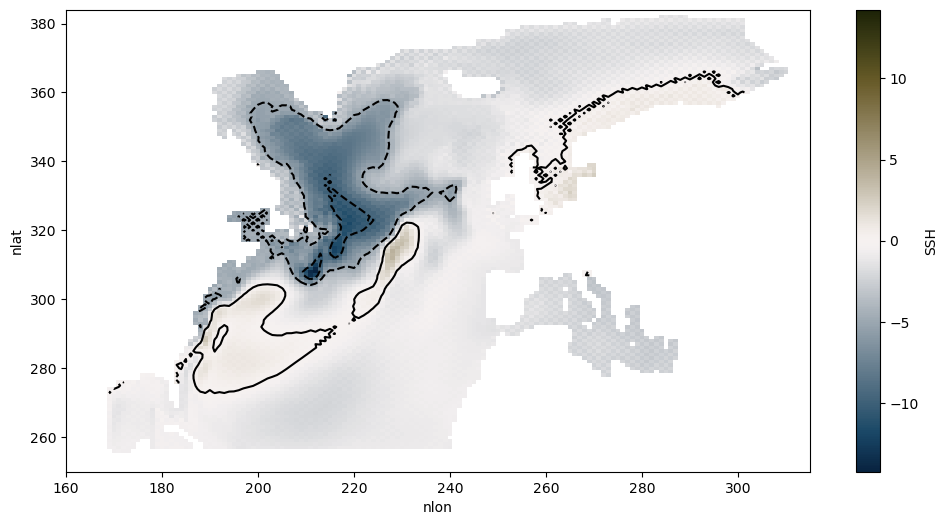

In [21]:
plt.figure(figsize=(12, 6))
#differences_plot = difference_ssh.plot(cmap=cmo.diff)#, vmin=vmin_hmxl, vmax=vmax_hmxl)
difference_ssh_plot = difference_ssh.plot(cmap=cmo.diff)#, vmin=vmin_hmxl, vmax=vmax_hmxl)
plt.title('Mixed Layer Anomaly')
plt.xlim([160, 315])
plt.ylim([250, 384])
contour_ssh = difference_ssh.plot.contour(colors='k') 
plt.clabel(contour_salt, inline=False, fontsize=10)

# Density computations

In [22]:
period1_avg_sigma = ds_sigma.SIGMA_2.isel(time=slice(event-before, event-tp)).mean(dim='time')
period2_avg_sigma = ds_sigma.SIGMA_2.isel(time=slice(event+tp, event+after)).mean(dim='time')
difference_sigma = period2_avg_sigma - period1_avg_sigma

In [26]:
vmin_sigma, vmax_sigma = -0.5, 0.5  

# Latitudinal Density Anomaly

ValueError: DataArray must be 2d

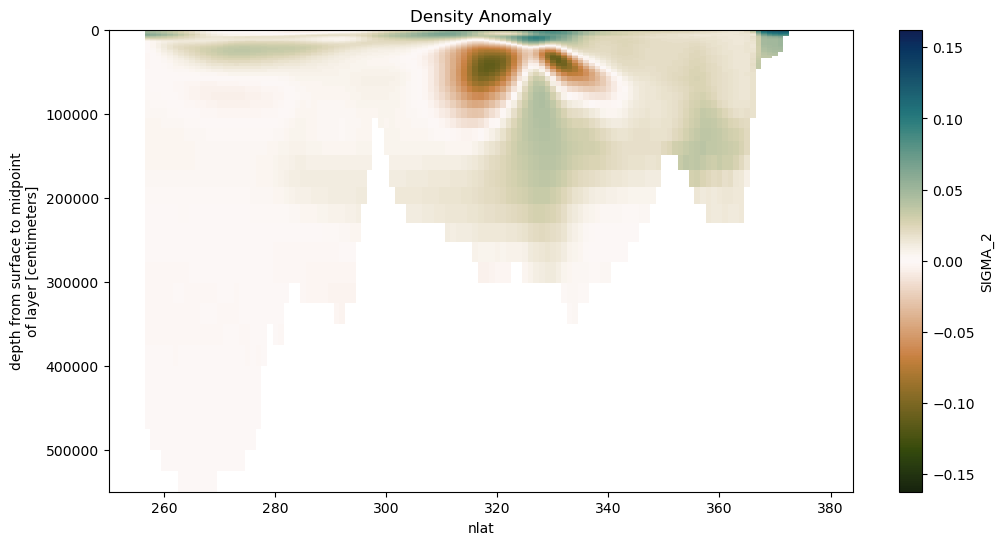

In [23]:
plt.figure(figsize=(12, 6))
#difference_salt_plot = difference_salt.plot(cmap=cmo.diff, vmin=vmin_salt, vmax=vmax_salt)
difference_sigma_plot = difference_sigma.isel(nlon=230).plot(cmap=cmo.tarn,yincrease=False)#, vmin=vmin_salt, vmax=vmax_salt)
plt.title('Density Anomaly')
#plt.xlim([160, 315])
plt.xlim([250, 384])
contour_salt = difference_sigma.plot.contour(colors='k') 
plt.clabel(contour_salt, inline=False, fontsize=10)

# 500-1000 meters Density Anomaly

ValueError: DataArray must be 2d

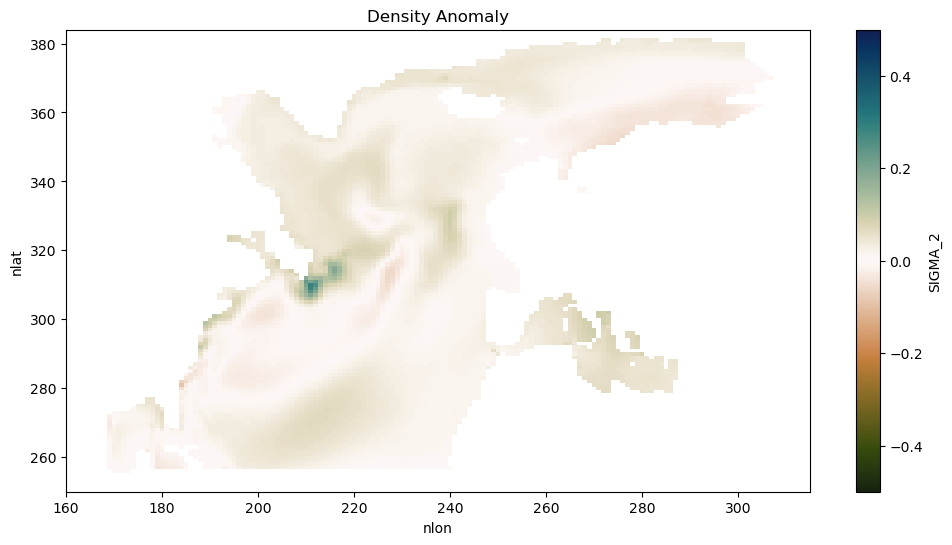

In [27]:
plt.figure(figsize=(12, 6))
#difference_salt_plot = difference_salt.plot(cmap=cmo.diff, vmin=vmin_salt, vmax=vmax_salt)
difference_sigma_plot = difference_sigma.isel(z_t=slice(14,20)).mean(dim='z_t').plot(cmap=cmo.tarn, vmin=vmin_sigma, vmax=vmax_sigma)
plt.title('Density Anomaly')
plt.xlim([160, 315])
plt.ylim([250, 384])
contour_salt = difference_sigma.plot.contour(colors='k') 
plt.clabel(contour_salt, inline=False, fontsize=10)

ValueError: DataArray must be 2d

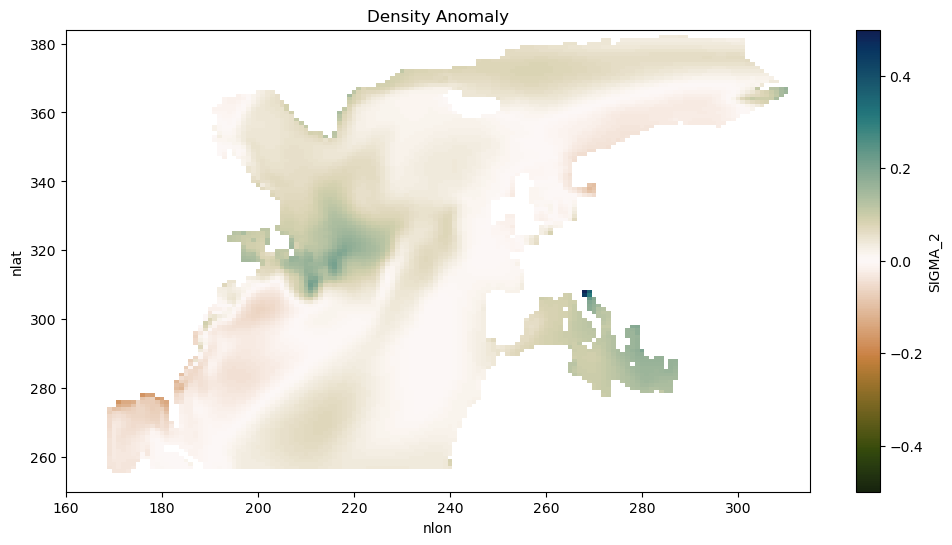

In [28]:
plt.figure(figsize=(12, 6))
#difference_salt_plot = difference_salt.plot(cmap=cmo.diff, vmin=vmin_salt, vmax=vmax_salt)
difference_sigma_plot = difference_sigma.isel(z_t=slice(0,14)).mean(dim='z_t').plot(cmap=cmo.tarn, vmin=vmin_sigma, vmax=vmax_sigma)
plt.title('Density Anomaly')
plt.xlim([160, 315])
plt.ylim([250, 384])
contour_salt = difference_sigma.plot.contour(colors='k') 
plt.clabel(contour_salt, inline=False, fontsize=10)